# Polyiamonds

Working ... https://puzzler.sourceforge.net/docs/FAQ.html#

A Puzzle grid selector tool is also provided [here](https://smilingwayne.github.io/PuzzleTools/)!



In [100]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from collections import defaultdict

In [127]:
def get_rectified_coord(x, y, z, theta):
    """Get Rectified Coordinates via (x, y, z) and theta (in degree form).
    """
    radian = np.deg2rad(theta)
    if z == 0:
        return [(x + y * np.cos(radian), y * np.sin(radian)), 
                (x + y * np.cos(radian) + 1, y * np.sin(radian)),
                (x + y * np.cos(radian) + np.cos(radian), (y + 1) * np.sin(radian))
               ]
    elif z == 1:
        return [
            (x + y * np.cos(radian) + np.cos(radian), (y + 1) * np.sin(radian)),
            (x + y * np.cos(radian) + np.cos(radian) + 1, (y + 1) * np.sin(radian)),
            (x + y * np.cos(radian) + 1, y * np.sin(radian))
        ]
    else: 
        print(f"Invalid z coord (only 1 or 0)! Found {z}!")
        return []

# The neighbors of the triangle at coordinates (x, y, 0) are:
# {(x, y, 1), (x-1, y, 1), (x, y-1, 1)}
# The neighbors of the triangle at coordinates (x, y, 1) are:
# {(x, y, 0), (x+1, y, 0), (x, y+1, 0)}

def round_point(point):
    return tuple(map(lambda x: round(x, 5), point))

def round_coords(segments):
    return list(map(lambda line: (round_point(line[0]), round_point(line[1])), segments))

def get_border(coords, theta): 
    candidates = set()
    removed_edge = set()
    final_edges = list()
    for (x, y, z) in coords: 
        candidates.add(f"{x}_{y}_{z}")
        if z == 0: 
            if f"{x}_{y}_{1}" in candidates: 
                removed_edge.add(f"{x}_{y}_{0}_{1}") 
                removed_edge.add(f"{x}_{y}_{1}_{2}") 

            if f"{x - 1}_{y}_{1}" in candidates:  
                removed_edge.add(f"{x}_{y}_{0}_{2}")
                removed_edge.add(f"{x - 1}_{y}_{1}_{1}")

            if f"{x}_{y - 1}_{1}" in candidates: 
                removed_edge.add(f"{x}_{y}_{0}_{0}")
                removed_edge.add(f"{x}_{y - 1}_{1}_{0}")

        elif z == 1: 
            if f"{x}_{y}_{0}" in candidates: 
                removed_edge.add(f"{x}_{y}_{1}_{2}")
                removed_edge.add(f"{x}_{y}_{0}_{1}")
                
            if f"{x + 1}_{y}_{0}" in candidates: 
                removed_edge.add(f"{x}_{y}_{1}_{1}")
                removed_edge.add(f"{x + 1}_{y}_{0}_{2}")

            if f"{x}_{y + 1}_{0}" in candidates: 
                removed_edge.add(f"{x}_{y}_{1}_{0}")
                removed_edge.add(f"{x}_{y + 1}_{0}_{0}")
    for (x, y, z) in coords: 
        pos = get_rectified_coord(x, y, z, theta)
        for i in range(3): 
            if f"{x}_{y}_{z}_{i}" in removed_edge: 
                continue 
            else:
                final_edges.append([pos[i % 3], pos[(i + 1) % 3]])
    return final_edges 
            

def organize_segments(segments):
    # 将每个线段转化为点对字典
    point_dict = {}
    for (x1, y1), (x2, y2) in segments:
        point_dict.setdefault((x1, y1), []).append((x2, y2))
        point_dict.setdefault((x2, y2), []).append((x1, y1))

    # 从其中一个点开始重新构建闭合路径
    start_point = segments[0][0]
    current_point = start_point
    organized_path = [start_point]

    while len(organized_path) != len(segments) + 1:
        # 从当前点选择下一个点
        next_point = point_dict[current_point][0]  # 选择尚未访问的下一个点
        # 移动到下一个点
        point_dict[current_point].remove(next_point)
        point_dict[next_point].remove(current_point)
        organized_path.append(next_point)
        current_point = next_point

    return organized_path

def clear_padding(coords):
    """Adjust the shape to border.

    Args:
        coords (_type_): _description_

    Returns:
        _type_: _description_
    """
    min_x = min(x for x, _, _ in coords) 
    min_y = min(y for _, y, _ in coords) 
    offset_x = min_x - 0
    offset_y = min_y - 0 

    if offset_x > 0 or offset_y > 0:
        new_coords = []
        for (x, y, z) in coords: 
            new_coords.append((x - offset_x, y - offset_y, z))
        return new_coords 
    else:
        return coords

def flap_120(coords):
    max_x = max(x for x, _, _ in coords)
    max_y = max(y for _, y, _ in coords)
    axis_ = max(max_x, max_y)
    flap_coords = []
    for (x, y, z) in coords: 
        if z == 1: 
            flap_coords.append((axis_ - y, axis_ - x, 0))
        elif z == 0:
            flap_coords.append((axis_ - y, axis_ - x, 1))
        else:
            print(f"Invalid coords: {z}, should be 0 or 1.")
    return clear_padding(flap_coords) 

def flap_90(coords):
    max_xy = max([ x + y if z == 0 else x + y + 1 for (x, y, z) in coords])
    new_coords = []
    for (x, y, z) in coords: 
        if z == 0: 
            new_coords.append((max_xy - x - y, y, z))
        else:
            new_coords.append((max_xy - x - y - 1, y, z))
    return clear_padding(new_coords)

def flap_30(coords):
    flap_coords = [] 
    for (x, y, z) in coords: 
        flap_coords.append((y, x, z)) 
    return clear_padding(flap_coords)

def all_possible_rotations(coords, opts = ["flap_90", "flap_120", "flap_30"]): 
    final_coords = [coords]
    for idx, opt in enumerate(opts): 
        if opt == "flap_90":
            next_coords = flap_90(coords)
        elif opt == "flap_120": 
            next_coords = flap_120(coords)
        elif opt == "flap_30":
            next_coords = flap_30(coords)
        new_coords = all_possible_rotations(next_coords, opts[: idx] + opts[idx + 1:])
        final_coords = final_coords +  new_coords
    return final_coords

def remove_dup(coords):
    seen = set()
    result = []
    for sublist in coords:
        # 将子列表中的元组排序并转换为元组作为唯一标识
        sorted_sublist = sorted(sublist)
        key = tuple(sorted_sublist)
        if key not in seen:
            seen.add(key)
            result.append(sublist)
    return result

def plot_polyiamond(coords_list):
    
    theta = 60
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    
    for idx, coord in enumerate(coords_list):
        temp_coords = get_border(coord, theta)
        temp_coords = round_coords(temp_coords)
        temp_coords = organize_segments(temp_coords)

        polygon = Polygon(temp_coords, closed=True, fill=True, edgecolor='black', facecolor='skyblue', alpha=0.5)
        ax.add_patch(polygon)
        
        # 设置坐标轴的标签和标题
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-1, 15)
    ax.set_ylim(-1, 15)
    ax.grid()
    ax.set_title('Filled Polygon from Line Segments')
    plt.show()

if __name__ == "__main__": 
    triangles = [
        # (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1),(0, 1, 0), (0, 1, 1),(0, 2, 0), (0, 2, 1),(1, 2, 0), (1, 2, 1)
        # rhomboid
        # (0, 0, 0), (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1),
        # (2, 0, 0), (0, 1, 0)
        # club: 
        # (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1), 
        # (2, 0, 0), (2, 0, 1), 
        # (0, 1, 0)
        # Crown:
        # (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1), 
        # (2, 0, 0), (2, 0, 1), 
        # (1, 1, 0)
        # Sphinx: 
        # (0, 0, 0), (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1),
        # (2, 0, 0), 
        # (0, 1, 0)
        # Snake: 
        # (0, 0, 1), 
        # (0, 1, 0), (0, 1, 1), 
        # (1, 1, 0), (1, 1, 1),
        # (1, 2, 0)
        # Yacht: 
        # (0, 0, 0), (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1), 
        # (0, 1, 0), (1, 1, 0)
        # Bat:
        # (0, 0, 0), (0, 0, 1), 
        # (1, 0, 0), (1, 0, 1), 
        # (1, 1, 0), (1, 1, 1)
        # Pistol:
        # (0, 0, 1), 
        # (0, 1, 0), (0, 1, 1), 
        # (1, 1, 0), (1, 1, 1),
        # (0, 2, 0)
        # Lobster:
        # (0, 0, 1), 
        # (0, 1, 0), (0, 1, 1),
        # (0, 2, 0),
        # (1, 0, 1), 
        # (1, 1, 0)
        # Hook:
        # (0, 0, 0), (0, 0, 1),
        # (0, 1, 0), (0, 1, 1),
        # (1, 0, 1), (1, 1, 0)
        # Hexagon:
        # (0, 0, 1), 
        # (0, 1, 0), (0, 1, 1),
        # (1, 0, 0), (1, 0, 1), 
        # (1, 1, 0)
        # Butterfly:
        (0, 1, 1), 
        (1, 0, 1), (1, 0, 0), 
        (2, 0, 0), 
        (1, 1, 0), (1, 1, 1)
        
        # For Test:
        # (0, 0, 1),
        # (1, 0, 0), (1, 0, 1), 
        # (0, 1, 0), (0, 1, 1),
        # (1, 1, 0), (2, 0, 0)
    ]
    all_coords = all_possible_rotations(triangles)

    all_coords = remove_dup(all_coords)

    # for x in all_coords: 
    #     print(x)
    #     plot_polyiamond([x])
    # plot_polyiamond(all_coords)
    

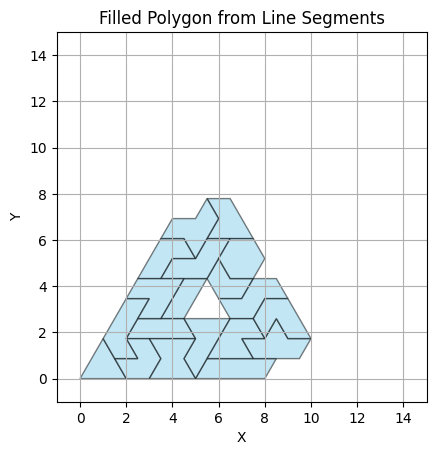

In [132]:
plot_polyiamond(result)

In [ ]:
def get_polyiamonds_by_size(size):
    shapes = []
    if size == 6: 
        shapes = [
        # rhomboid
        [
            (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (0, 1, 0)
        ], 
        # club: 
        [
            (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1), (0, 1, 0)
        ],
        # Crown:
        [   
            (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1), (1, 1, 0)
        ],
        # Sphinx: 
        [
            (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (0, 1, 0)
        ],
        # Snake: 
        [   
            (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 2, 0)
        ],
        # Yacht: 
        [   
            (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (0, 1, 0), (1, 1, 0)
        ],
        # Bat:
        [
            (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)
        ],
        # Pistol:
        [
            (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (0, 2, 0)
        ],
        # Lobster:
        [
            (0, 0, 1), (0, 1, 0), (0, 1, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0)
        ],
        # Hook:
        [
            (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0)
        ],
        # Hexagon:
        [
            (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)
        ],
        # Butterfly:
        [
            (0, 1, 1), (1, 0, 1), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 1, 1)
        ]
    ]
    if size == 5:
        shapes = [
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0)
            ],
            [
                (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)
            ],
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)
            ],
            [
                (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1), (1, 1, 0)
            ],
        ]
    if size == 4:
        shapes = [
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1)
            ],
            [
                (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)
            ],
            [
                (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0)
            ],
        ]
    if size == 3:
        shapes = [
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0)
            ]
        ]
    if size == 2:
        return [
            [
                (0, 0, 0), (0, 0, 1)
            ]
        ]
    return shapes

In [109]:
from collections import defaultdict 
from ortools.sat.python import cp_model as cp

In [110]:
def generate_grid(name):
    if name == "4x9":
        return {
            "x": 9, 
            "y": 4,
            "grid": ",".join([f"{a}_{b}_{c}" for a in range(9) for b in range(4) for c in range(2)])
        }
    if name == "6x6":
        return {
            "x": 6,
            "y": 6,
            "grid": ",".join([f"{a}_{b}_{c}" for a in range(6) for b in range(6) for c in range(2)])
        }
    

class Grid:
    def __init__(self, grid_dict):
        self.width = grid_dict['x']
        self.height = grid_dict['y']
        self.grid_str = grid_dict['grid'] 
        self.positions = set(tuple(int(part) for part in coord.split('_')) for coord in self.grid_str.split(','))
        
    def get_all_feasible_pos(self, shape): 
        candidates = defaultdict(list)
        for x_1 in range(self.width):
            for y_1 in range(self.height):
                if self.check_fit(shape, x_1, y_1):
                    candidates[x_1, y_1].append(shape)
        return candidates

    def check_fit(self, shape, x_, y_):
        """Check if "shape" can be fit into position (x_, y_).

        Args:
            shape (_type_): _description_
            x_ (_type_): _description_
            y_ (_type_): _description_

        Returns:
            _type_: _description_
        """
        for (x, y, z) in shape: 
            if (x + x_, y + y_, z) not in self.positions:
                return False 
        return True
if __name__ == "__main__":
    test_grid = generate_grid("4x9")
    dummy_grid = Grid(test_grid)
    # print(dummy_grid.check_fit(triangles, 0, 0))
    test_candidates = dummy_grid.get_all_feasible_pos(triangles)
    print(test_candidates)


defaultdict(<class 'list'>, {(0, 0): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (0, 1): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (0, 2): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (1, 0): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (1, 1): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (1, 2): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (2, 0): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (2, 1): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (2, 2): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (3, 0): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (3, 1): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (3, 2): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (4, 0): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (4, 1): [[(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 1, 1)]], (4, 2): [[(0, 0, 0), (0, 0, 1), (

In [ ]:
def get_polyiamonds_by_size(sizes):
    sizes = set(sizes)
    shapes = []
    for size in sizes:
        if size == 6: 
            shapes += [
            # rhomboid
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1)
            ], 
            # club: 
            [
                (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1), (0, 1, 0)
            ],
            # Crown:
            [   
                (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (2, 0, 1), (1, 1, 0)
            ],
            # Sphinx: 
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0), (0, 1, 0)
            ],
            # Snake: 
            [   
                (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (1, 2, 0)
            ],
            # Yacht: 
            [   
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (0, 1, 0), (1, 1, 0)
            ],
            # Bat:
            [
                (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)
            ],
            # Pistol:
            [
                (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (0, 2, 0)
            ],
            # Lobster:
            [
                (0, 0, 1), (0, 1, 0), (0, 1, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0)
            ],
            # Hook:
            [
                (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0)
            ],
            # Hexagon:
            [
                (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)
            ],
            # Butterfly:
            [
                (0, 1, 1), (1, 0, 1), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 1, 1)
            ]
        ]
        if size == 5:
            shapes += [
                [
                    (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 0)
                ],
                [
                    (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)
                ],
                [
                    (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)
                ],
                [
                    (0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1), (1, 1, 0)
                ],
            ]
        if size == 4:
            shapes += [
                [
                    (0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1)
                ],
                [
                    (0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)
                ],
                [
                    (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0)
                ],
            ]
        if size == 3:
            shapes += [
                [
                    (0, 0, 0), (0, 0, 1), (1, 0, 0)
                ]
            ]
        if size == 2:
            shapes += [
            [
                (0, 0, 0), (0, 0, 1)
            ]
        ]
    return shapes


if __name__ == "__main__":
    temp_cands = get_polyiamonds_by_size([6,5])
    

16


In [120]:
def generate_grid(name = "default", raw_grid = None):
    if name == "4x9":
        return {
            "x": 9, 
            "y": 4,
            "grid": ",".join([f"{a}_{b}_{c}" for a in range(9) for b in range(4) for c in range(2)])
        }
    if name == "6x6":
        return {
            "x": 6,
            "y": 6,
            "grid": ",".join([f"{a}_{b}_{c}" for a in range(6) for b in range(6) for c in range(2)])
        }
    if raw_grid: 
        # parse grid to standard format!
        raw_grid = clear_padding(raw_grid) 
        max_x = 0
        max_y = 0
        for (x, y, z) in raw_grid:
            max_x = max(max_x, x)
            max_y = max(max_y, y)
        return {
            "x": max_x + 1, 
            "y": max_y + 1,
            "grid": ",".join([f"{x}_{y}_{z}" for (x, y, z) in raw_grid])
        }
    else:
        return {}
        
        
if __name__ == "__main__":
    test_grid = generate_grid(name = "4x9")
    # print(test_grid)
    raw_grid = [(0,1,1), (0,2,0), (0,2,1), (0,3,0), (0,3,1), (1,0,1), (1,1,0), (1,1,1), (1,2,0), (1,2,1), (1,3,0), (1,3,1), (2,0,0), (2,0,1), (2,1,0), (2,1,1), (2,2,0), (2,2,1), (2,3,0), (2,3,1), (3,0,0), (3,0,1), (3,1,0), (3,1,1), (3,2,0), (3,2,1), (3,3,0), (3,3,1), (4,0,0), (4,0,1), (4,1,0), (4,1,1), (4,2,0), (4,2,1), (4,3,0), (4,3,1), (5,0,0), (5,0,1), (5,1,0), (5,1,1), (5,2,0), (5,2,1), (5,3,0), (5,3,1), (6,0,0), (6,0,1), (6,1,0), (6,1,1), (6,2,0), (6,2,1), (6,3,0), (6,3,1), (7,0,0), (7,0,1), (7,1,0), (7,1,1), (7,2,0), (7,2,1), (7,3,0), (7,3,1), (8,0,0), (8,0,1), (8,1,0), (8,1,1), (8,2,0), (8,2,1), (8,3,0), (9,0,0), (9,0,1), (9,1,0), (9,1,1), (9,2,0)]
    test_grid = generate_grid(name = "diamond", raw_grid=raw_grid)
    print(test_grid)

{'x': 10, 'y': 4, 'grid': '0_1_1,0_2_0,0_2_1,0_3_0,0_3_1,1_0_1,1_1_0,1_1_1,1_2_0,1_2_1,1_3_0,1_3_1,2_0_0,2_0_1,2_1_0,2_1_1,2_2_0,2_2_1,2_3_0,2_3_1,3_0_0,3_0_1,3_1_0,3_1_1,3_2_0,3_2_1,3_3_0,3_3_1,4_0_0,4_0_1,4_1_0,4_1_1,4_2_0,4_2_1,4_3_0,4_3_1,5_0_0,5_0_1,5_1_0,5_1_1,5_2_0,5_2_1,5_3_0,5_3_1,6_0_0,6_0_1,6_1_0,6_1_1,6_2_0,6_2_1,6_3_0,6_3_1,7_0_0,7_0_1,7_1_0,7_1_1,7_2_0,7_2_1,7_3_0,7_3_1,8_0_0,8_0_1,8_1_0,8_1_1,8_2_0,8_2_1,8_3_0,9_0_0,9_0_1,9_1_0,9_1_1,9_2_0'}


In [133]:

class Grid:
    def __init__(self, grid_dict):
        self.width = grid_dict['x']
        self.height = grid_dict['y']
        self.grid_str = grid_dict['grid'] 
        self.positions = set(tuple(int(part) for part in coord.split('_')) for coord in self.grid_str.split(','))
        self.cand_shapes = grid_dict['cand_shapes']
        self.model = cp.CpModel() 
        self.solver = cp.CpSolver()
        self.x = dict()  # variables
        self.avail_variables = defaultdict(list) # record available variables of each cell
        self.shape_type = defaultdict(list)
        
    def get_all_feasible_pos(self, shape): 
        candidates = set()
        for x_1 in range(self.width):
            for y_1 in range(self.height):
                if self.check_fit(shape, x_1, y_1):
                    candidates.add((x_1, y_1))
        return candidates

    def check_fit(self, shape, x_, y_):
        for (x, y, z) in shape: 
            if (x + x_, y + y_, z) not in self.positions:
                return False 
        return True

    def add_all_vars(self): 
        for shape_name, shape in self.cand_shapes.items(): 
            temp_type, temp_index = shape_name[0], shape_name[1]
            
            cur_cand_pos = self.get_all_feasible_pos(shape) 
            
            for (x_1, y_1) in cur_cand_pos:
                self.x[f"{temp_type}_{temp_index}_{x_1}_{y_1}"] = self.model.NewBoolVar(f"{temp_type}_{temp_index}_{x_1}_{y_1}")
                for (x_2, y_2, z_2) in shape: 
                    # Exact Cover must start from the grid!
                    self.avail_variables[x_1 + x_2, y_1 + y_2, z_2].append(self.x[f"{temp_type}_{temp_index}_{x_1}_{y_1}"])
                self.shape_type[temp_type].append(self.x[f"{temp_type}_{temp_index}_{x_1}_{y_1}"])
        
        for temp_type, temp_vars in self.shape_type.items():
            self.model.Add(sum(temp_vars) <= 1 )
            pass


        for k, avail_vars in self.avail_variables.items(): 
            # Adjust here!!!!
            if (int(k[0]), int(k[1]), int(k[2])) in self.positions: 
                self.model.Add(sum(avail_vars) == 1) 
            # each cell must be filled exactly once.


    def solve(self): 
        self.add_all_vars() 
        status = self.solver.Solve(self.model)
        result = []
        if status == cp.OPTIMAL:
            print("Found!")
            for k_ in self.x.keys(): 
                if self.solver.Value(self.x[k_]) > 1e-5: 
                    shape_info = list(map(int, k_.split("_")))
                    cur_shape = self.cand_shapes[shape_info[0], shape_info[1]]
                    cur_res = []
                    for (x_2, y_2, z_2) in cur_shape: 
                        cur_res.append([x_2 + shape_info[2], y_2 + shape_info[3], z_2])
                    result.append(cur_res)
            print(result)
        
        else:
            print("Can't find Optimal.")
        return result


    
if __name__ == "__main__":
    # test_grid = generate_grid("4x9")
    # raw_grid = [(0,1,1), (0,2,0), (0,2,1), (0,3,0), (0,3,1), (1,0,1), (1,1,0), (1,1,1), (1,2,0), (1,2,1), (1,3,0), (1,3,1), (2,0,0), (2,0,1), (2,1,0), (2,1,1), (2,2,0), (2,2,1), (2,3,0), (2,3,1), (3,0,0), (3,0,1), (3,1,0), (3,1,1), (3,2,0), (3,2,1), (3,3,0), (3,3,1), (4,0,0), (4,0,1), (4,1,0), (4,1,1), (4,2,0), (4,2,1), (4,3,0), (4,3,1), (5,0,0), (5,0,1), (5,1,0), (5,1,1), (5,2,0), (5,2,1), (5,3,0), (5,3,1), (6,0,0), (6,0,1), (6,1,0), (6,1,1), (6,2,0), (6,2,1), (6,3,0), (6,3,1), (7,0,0), (7,0,1), (7,1,0), (7,1,1), (7,2,0), (7,2,1), (7,3,0), (7,3,1), (8,0,0), (8,0,1), (8,1,0), (8,1,1), (8,2,0), (8,2,1), (8,3,0), (9,0,0), (9,0,1), (9,1,0), (9,1,1), (9,2,0)]
    # raw_grid = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (0,2,0), (0,2,1), (0,3,0), (0,3,1), (0,4,0), (0,4,1), (0,5,0), (0,5,1), (0,6,0), (0,6,1), (0,7,0), (0,7,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1), (1,2,0), (1,2,1), (1,3,0), (1,3,1), (1,4,0), (1,4,1), (1,5,0), (1,5,1), (1,6,0), (1,6,1), (1,7,0), (1,7,1), (1,8,0), (1,8,1), (2,0,0), (2,0,1), (2,1,0), (2,1,1), (2,2,0), (2,2,1), (2,3,0), (2,3,1), (2,4,0), (2,4,1), (2,5,0), (2,5,1), (2,6,0), (2,6,1), (2,7,0), (2,7,1), (2,8,0), (3,0,0), (3,0,1), (3,1,0), (3,1,1), (3,2,0), (3,2,1), (3,4,1), (3,5,0), (3,5,1), (3,6,0), (3,6,1), (3,7,0), (4,0,0), (4,0,1), (4,1,0), (4,1,1), (4,2,0), (4,2,1), (4,3,1), (4,4,0), (4,4,1), (4,5,0), (4,5,1), (4,6,0), (5,0,0), (5,0,1), (5,1,0), (5,1,1), (5,2,0), (5,2,1), (5,3,0), (5,3,1), (5,4,0), (5,4,1), (6,0,0), (6,0,1), (6,1,0), (6,1,1), (6,2,0), (6,2,1), (6,3,0), (6,3,1), (6,4,0), (7,0,0), (7,0,1), (7,1,0), (7,1,1), (7,2,0), (7,2,1), (7,3,0), (8,1,0), (8,1,1), (8,2,0)]
    raw_grid = [(1,1,0), (1,1,1), (1,2,0), (1,2,1), (1,3,0), (1,3,1), (1,4,0), (1,4,1), (1,5,0), (1,5,1), (1,6,0), (1,6,1), (1,7,0), (1,7,1), (1,8,0), (1,8,1), (1,9,0), (1,9,1), (2,1,0), (2,1,1), (2,2,0), (2,2,1), (2,3,0), (2,3,1), (2,4,0), (2,4,1), (2,5,0), (2,5,1), (2,6,0), (2,6,1), (2,7,0), (2,7,1), (2,8,0), (2,8,1), (2,9,0), (2,9,1), (3,1,0), (3,1,1), (3,2,0), (3,2,1), (3,3,0), (3,3,1), (3,4,0), (3,4,1), (3,5,0), (3,5,1), (3,6,0), (3,6,1), (3,7,0), (3,7,1), (3,8,0), (3,8,1), (3,9,0), (4,1,0), (4,1,1), (4,2,0), (4,2,1), (4,3,0), (4,3,1), (4,4,0), (4,4,1), (4,5,0), (4,5,1), (4,6,0), (4,6,1), (5,1,0), (5,1,1), (5,2,0), (5,2,1), (5,3,0), (5,3,1), (5,4,0), (5,4,1), (5,5,0), (5,5,1), (5,6,0), (5,6,1), (6,1,0), (6,1,1), (6,2,0), (6,2,1), (6,3,0), (6,3,1), (6,4,0), (6,4,1), (6,5,0), (6,5,1), (7,1,0), (7,1,1), (7,2,0), (7,2,1), (7,3,0), (7,3,1), (8,1,0), (8,1,1), (8,2,0), (8,2,1), (8,3,0), (8,3,1), (9,1,0), (9,1,1), (9,2,0), (9,2,1), (9,3,0)]
    test_grid = generate_grid(name = "diamond", raw_grid=raw_grid)
    # print(test_grid)
    cand_shape = get_polyiamonds_by_size([6,5,4])
    # cand_shape2 = get_polyiamonds_by_size(5)
    
    all_cand_shapes = dict()
    record_shapes2 = list()
    for idx, shape in enumerate(cand_shape):  

        new_shapes = all_possible_rotations(shape)
        # print(len(new_shapes)) 
        new_shapes = remove_dup(new_shapes)
        for n_shape in new_shapes: 
            record_shapes2.append(n_shape)
        # print(len(new_shapes))
        for idx_2, new_shape in enumerate(new_shapes): 
            all_cand_shapes[idx, idx_2] = new_shape
            # with rotation and flip ... 
    test_grid['cand_shapes'] = all_cand_shapes
    dummy_grid = Grid(test_grid)
    result = dummy_grid.solve()

    # test_candidates = dummy_grid.get_all_feasible_pos(triangles)

Found!
[[[4, 3, 0], [4, 3, 1], [5, 3, 0], [5, 3, 1]], [[3, 0, 0], [3, 0, 1], [3, 1, 0], [4, 0, 0]], [[6, 0, 1], [6, 1, 0], [6, 1, 1], [7, 1, 0]], [[3, 2, 1], [4, 2, 0], [4, 2, 1], [5, 2, 0], [5, 2, 1]], [[0, 0, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 1, 1]], [[1, 8, 1], [1, 8, 0], [0, 8, 1], [0, 8, 0], [0, 7, 1]], [[0, 6, 1], [0, 7, 0], [1, 6, 0], [1, 6, 1], [1, 7, 0]], [[4, 0, 1], [4, 1, 0], [3, 1, 1], [3, 2, 0], [2, 2, 1], [2, 3, 0]], [[8, 2, 0], [7, 2, 1], [7, 2, 0], [6, 2, 1], [6, 2, 0], [8, 1, 1]], [[2, 6, 0], [2, 6, 1], [2, 7, 0], [2, 7, 1], [2, 8, 0], [1, 7, 1]], [[0, 2, 0], [0, 2, 1], [0, 3, 0], [0, 3, 1], [0, 4, 0], [1, 2, 0]], [[3, 3, 0], [2, 3, 1], [2, 4, 0], [2, 4, 1], [2, 5, 0], [1, 5, 1]], [[3, 5, 1], [4, 5, 0], [4, 4, 1], [5, 4, 0], [4, 5, 1], [5, 4, 1]], [[1, 4, 0], [1, 3, 1], [1, 3, 0], [1, 2, 1], [2, 2, 0], [2, 1, 1]], [[2, 5, 1], [3, 5, 0], [3, 4, 1], [3, 4, 0], [3, 3, 1], [4, 4, 0]], [[0, 4, 1], [0, 5, 0], [0, 5, 1], [0, 6, 0], [1, 4, 1], [1, 5, 0]], [[7, 0, 0], [7